In [1]:
import pandas as pd
import numpy as np

from os import listdir

import xlrd

import matplotlib.pyplot as plt

# АПВО

In [2]:
def get_apvo(path_to_folder='АПВО'):
    """
    Считывание и предобработка АПВО
    
    Parameters:
    path_to_folder (str): Путь до папки с файлами АПВО
    
    Returns:
    data_apvo (pd.DataFrame): Все данные по АПВО
    """
    
    # датафрейм для закидывания листов
    data_apvo = pd.DataFrame(columns=[
        'Предприятие', 'Тип машины', 'Объем нар. итог', 'Участок работ', 'Вид работ', 'Вып. объем физич.', 'Вып. объем с прох.', 'Продолжительность ОКНА план/факт'
    ])
    
    for file in listdir(path=path_to_folder):
        apvo = pd.ExcelFile(f'{path_to_folder}/{file}')
        
        print(f'{file}')

        # в цикле считываем листы, удаляем ненужное, добавляем дату, добавляем все в основной датафрейм
        for date in apvo.sheet_names:
            if date.isdigit():
                # парсим год и месяц
                try:
                    month, year = (
                        xlrd
                        .open_workbook(f'{path_to_folder}/{file}')
                        .sheet_by_name(date)
                        .cell_value(2, 0)
                        .split('.')
                    )[1:]
                except:
                    workbook = xlrd.open_workbook(f'{path_to_folder}/{file}')
                    workbook_datemode = workbook.datemode

                    year, month = xlrd.xldate_as_tuple(
                        workbook.sheet_by_index(0).cell_value(2, 0),
                        workbook_datemode
                    )[:2]

                # читаме лист
                data = pd.read_excel(
                    f'{path_to_folder}/{file}',
                    sheet_name=date,
                    header=4,
                    usecols=np.arange(0, 8),
                    names = [
                        'Предприятие',
                        'Тип машины',
                        'Объем нар. итог',
                        'Участок работ',
                        'Вид работ',
                        'Вып. объем физич.',
                        'Вып. объем с прох.',
                        'Продолжительность ОКНА план/факт'
                    ]
                )

                data = data.loc[:data.shape[0] - 4]

                try:
                    data['date'] = pd.to_datetime(f'{year}-{month}-{date}')
                except:
                    print(f'Bad date - {year}-{month}-{date}')
                    continue

                data_apvo = data_apvo.append(data, ignore_index=True)
        
        
    # дропаем ненужные столбцы
    data_apvo.drop(columns=['Предприятие', 'Объем нар. итог', 'Участок работ', 'Вып. объем с прох.'], inplace=True)


    # делим тип машины и номер на 2 столбца
    machine_type_splitted = data_apvo['Тип машины'].str.split('№', expand=True)

    data_apvo['тип_машины'] = machine_type_splitted[0]
    try:
        data_apvo['номер_машины'] = machine_type_splitted.apply(lambda x: x[1] if x[2] == None else x[2], axis=1).str.strip().astype(int)
    except:
        data_apvo['номер_машины'] = machine_type_splitted[1].astype(int)

    data_apvo.drop(columns=['Тип машины'], inplace=True)


    # делим работу на значения и единицы измерения
    data_apvo.loc[data_apvo['Вып. объем физич.'] == '\xa0', 'Вып. объем физич.'] = np.NaN

    data_apvo['вып_объем_физич'] = data_apvo['Вып. объем физич.'].str.split(expand=True)[0].astype(float)
    data_apvo['вып_объем_физич_eд'] = data_apvo['Вып. объем физич.'].str.split(expand=True)[1]
    
    data_apvo['вып_объем_физич_eд'] = data_apvo['вып_объем_физич_eд'].str.lower().copy()
    
    
    # извлекаем продолжительность окна план
    data_apvo['окно_план'] = data_apvo['Продолжительность ОКНА план/факт'].str.split('/', expand=True)[0]
    data_apvo.loc[data_apvo['окно_план'] == 'НЕТ ЗАЯВОК', 'окно_план'] = np.NaN
    data_apvo['окно_план'] = data_apvo['окно_план'].astype(float)
    
    data_apvo.drop(columns=['Вып. объем физич.', 'Продолжительность ОКНА план/факт'], inplace=True)
        
    return data_apvo

In [7]:
data_apvo = get_apvo()

АПВО август 20.xls
АПВО апрель 19.xls
АПВО апрель 20.xls
АПВО июль 20.xls
АПВО июнь 19.xls
АПВО июнь 20.xls
АПВО май 19.xls
АПВО май 20.xls
АПВО октябрь 19.xls
АПВО сентябрь 20.xlsx


In [20]:
data_apvo.head()

,Вид работ,date,тип_машины,номер_машины,вып_объем_физич,вып_объем_физич_eд,окно_план
0,Работа УНИМАТ,2020-08-01,Унимат 08-275/3S,40,1.0,стрелка,120.0
1,Работа УНИМАТ,2020-08-01,Унимат 08-275/3S,40,1.0,стрелка,120.0
2,Работа УНИМАТ,2020-08-01,Унимат 08-275/3S,40,1.0,стрелка,120.0
3,Работа РПБ,2020-08-01,РПБ-01,108,3000.0,м,230.0
4,Работа ДУОМАТИК,2020-08-01,ДУОМАТИК 09-32 GSM,73,1000.0,м,230.0


In [87]:
data_apvo['номер_машины'].astype(float)

0         40.0
1         40.0
2         40.0
3        108.0
4         73.0
         ...  
37039     31.0
37040     78.0
37041     39.0
37042     31.0
37043     78.0
Name: номер_машины, Length: 37044, dtype: float64

In [81]:
data_apvo['номер_машины'].astype(float)

0         40.0
1         40.0
2         40.0
3        108.0
4         73.0
         ...  
37039     31.0
37040     78.0
37041     39.0
37042     31.0
37043     78.0
Name: номер_машины, Length: 37044, dtype: float64

In [80]:
data_apvo[data_apvo['вып_объем_физич_eд'].isin(['м'])]['Вид работ'].value_counts()

Работа ДУОМАТИК                                            2362
Работа РПБ                                                 1401
Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ДИНАМИК)    1036
Работа ДСП                                                 1026
Глубокая очистка щебня                                      712
Работа ПМА                                                  495
Работа СТРУГ                                                437
Работа гайковерта                                           409
Работа УНИМАТ                                               221
Работа ДСП, СПП                                             172
Выправка пути                                               172
Планировка балласта                                         143
Работа ЭЛБ                                                  111
Работа ВПО                                                   90
Работа СДПМ                                                  54
Работа СМ                               

In [83]:
data_apvo[data_apvo['вып_объем_физич_eд'].isin(['М'])]['Вид работ'].unique()

array(['Укладка плетей',
       'Смена инвентарных рельсов на плети бесстыкового пути',
       'Укладка рельсошпальной решетки'], dtype=object)

In [82]:
data_apvo[data_apvo['вып_объем_физич_eд'].isin(['М'])]

,Вид работ,date,тип_машины,номер_машины,вып_объем_физич,вып_объем_физич_eд,окно_план
599,Укладка плетей,2020-08-05,УК 25/9-18,462,800.0,М,480.0
654,Смена инвентарных рельсов на плети бесстыковог...,2020-08-05,УК 25/9-18,794,450.0,М,360.0
685,Смена инвентарных рельсов на плети бесстыковог...,2020-08-06,УК 25/9-18,794,450.0,М,360.0
2134,Укладка рельсошпальной решетки,2020-08-16,УК 25/9-18,597,800.0,М,230.0
5291,Укладка плетей,2019-04-09,УК 25/9-18,565,800.0,М,230.0
5293,Укладка плетей,2019-04-09,УК 25/9-18,565,800.0,М,360.0
5682,Укладка рельсошпальной решетки,2019-04-12,УК 25/9-18,332,450.0,М,230.0
5993,Укладка рельсошпальной решетки,2019-04-15,УК 25/9-18,693,4500.0,М,4320.0
12014,Укладка рельсошпальной решетки,2020-07-03,УК 25/9-18,334,1000.0,М,1440.0
12162,Укладка рельсошпальной решетки,2020-07-05,УК 25/9-18,334,1000.0,М,1440.0


# ССПС

In [3]:
def get_ssps(path_to_folder='ССПС'):
    """
    Считывание и предобработка ССПС
    
    Parameters:
    path_to_folder (str): Путь до папки с файлами ССПС
    
    Returns:
    data_apvo (pd.DataFrame): Все данные по ССПС
    """
    
    # датафрейм для закидывания листов
    data_ssps = pd.DataFrame(columns=[
        '№ п.п.', 'Машины', 'АУ-12', 'Расход топлива по норме', 'Расход топлива фактический', 'Экономия', 'Перерасход', 'Остаток в баках на конец периода'
    ])
    
    
    for file in listdir(path=path_to_folder):
        ssps = pd.ExcelFile(f'{path_to_folder}/{file}')
        
        print(f'{file}')

        # в цикле считываем листы, удаляем ненужное, добавляем дату, добавляем все в основной датафрейм
        for date in ssps.sheet_names:
            if date.isdigit():

                # читаем лист
                data = pd.read_excel(
                    f'{path_to_folder}/{file}',
                    sheet_name=date,
                    header=7,
                    usecols=np.arange(0, 8),
                    names = [
                        '№ п.п.',
                        'Машины',
                        'АУ-12',
                        'Расход топлива по норме',
                        'Расход топлива фактический',
                        'Экономия',
                        'Перерасход',
                        'Остаток в баках на конец периода'
                    ]
                )

                if data.shape[0] == 0:
                    continue

                # парсим месяц и год
                month, year = (
                    xlrd
                    .open_workbook(f'{path_to_folder}/{file}')
                    .sheet_by_name(date)
                    .cell_value(1, 0)
                    .split('.')
                )[-2:]

                try:
                    data['date'] = pd.to_datetime(f'{year}-{month}-{date}')
                except:
                    print(f'Bad date - {year}-{month}-{date}')
                    continue

                data_ssps = data_ssps.append(data, ignore_index=True)
        
        
    # дропаем ненужные столбцы
    data_ssps.drop(columns=['№ п.п.', 'АУ-12', 'Экономия', 'Перерасход', 'Остаток в баках на конец периода'], inplace=True)

    # корректируем расходы
    data_ssps.loc[data_ssps['Расход топлива по норме'] == '-', 'Расход топлива по норме'] = np.NaN
    data_ssps.loc[data_ssps['Расход топлива фактический'] == '-', 'Расход топлива фактический'] = np.NaN

    data_ssps['Расход топлива по норме'] = data_ssps['Расход топлива по норме'].astype(float)
    data_ssps['Расход топлива фактический'] = data_ssps['Расход топлива фактический'].astype(float)

    # делим тип машины и номер на 2 столбца
    machine_type_splitted = data_ssps['Машины'].str.split(' №', expand=True)

    data_ssps['тип_машины'] = machine_type_splitted[0]
    data_ssps['номер_машины'] = machine_type_splitted[1].str.split(expand=True)[0].astype(int)

    data_ssps.drop(columns=['Машины'], inplace=True)

    data_ssps.columns = ['расход_топлива_норма', 'расход_топлива_факт', 'date', 'тип_машины', 'номер_машины']

    return data_ssps

In [10]:
data_ssps = get_ssps()

работа апрель ССПС 20.xlsx
работа май ССПС 20.xlsx
работа ССПС август 20.xlsx
работа ССПС апрель 19.xlsx
работа ССПС июль 20.xlsx
работа ССПС июнь 20.xls
работа ССПС июнь 2019.xlsx
работа ССПС май 2019.xlsx
работа ССПС октябрь 2019.xlsx
работа ССПС сентябрь 20.xlsx


In [11]:
data_ssps.shape

(31605, 5)

# Merge

In [4]:
def save_merged_data(path_to_apvo='АПВО', path_to_ssps='ССПС'):
    """
    Мердж АПВО и ССПС, расчет удельного расхода, удление пропоусков, сохранение результата на диск.
    
    Parameters:
    path_to_apvo (str): Путь до папки с АПВО
    path_to_ssps (str): Путь до папки с ССПС
    """
    
    # inner join
    data = pd.merge(get_apvo(path_to_apvo), get_ssps(path_to_ssps), on=['тип_машины', 'номер_машины', 'date'])
    
    data = data[data['вып_объем_физич'] != 0].copy()
    
    # считаем таргеты
    data['удельный_расход_факт'] = data['расход_топлива_факт'] / data['вып_объем_физич']
#     data['удельный_расход_норма'] = data['расход_топлива_норма'] / data['вып_объем_физич']
    
    # удаляем объекты с пропусками в виде работ и удельном расходе
    data.dropna(subset=['Вид работ', 'удельный_расход_факт'], inplace=True)
    
    data.drop(columns='расход_топлива_норма', inplace=True)
    
    data = data.rename(columns={
        'date': 'Дата',
        'тип_машины': 'Тип машины',
        'номер_машины': 'Номер машины',
        'вып_объем_физич': 'Вып. объем физич.',
        'вып_объем_физич_eд': 'Вып. объем физич. eд.',
        'окно_план': 'Продолжительность ОКНА план',
        'расход_топлива_факт': 'Фактический расход топлива',
        'удельный_расход_факт': 'Удельный расход топлива'
    })
    
    data = data[[
        'Тип машины',
        'Вид работ',
        'Номер машины',
        'Дата',
        'Вып. объем физич.',
        'Вып. объем физич. eд.',
        'Продолжительность ОКНА план',
        'Фактический расход топлива',
        'Удельный расход топлива'
    ]].copy()
    
    data.to_excel('merged_data.xlsx')

In [97]:
save_merged_data()

АПВО август 20.xls
АПВО апрель 19.xls
АПВО апрель 20.xls
АПВО июль 20.xls
АПВО июнь 19.xls
АПВО июнь 20.xls
АПВО май 19.xls
АПВО май 20.xls
АПВО октябрь 19.xls
АПВО сентябрь 20.xlsx
работа апрель ССПС 20.xlsx
работа май ССПС 20.xlsx
работа ССПС август 20.xlsx
работа ССПС апрель 19.xlsx
работа ССПС июль 20.xlsx
работа ССПС июнь 20.xls
работа ССПС июнь 2019.xlsx
работа ССПС май 2019.xlsx
работа ССПС октябрь 2019.xlsx
работа ССПС сентябрь 20.xlsx


# Merged in dates range

In [5]:
def get_ranged(path_to_merged='merged_data.xlsx', start=None, end=None):
    """
    Возвращает смерженую таблицу за выбранный период.
    Если начало или конец не выбраны, подставляет минимальное и максимальное значение даты, соотвественно.
    
    Parameters:
    path_to_merged (str): Путь до файла с полной смержденой таблицей
    start (str): Начало периода в формате yyyy-mm-dd
    end (str): Конец периода в формате yyyy-mm-dd
    
    Returns:
    merged_data (pd.DataFrame): Смерженая таблица за выбранный период
    """
    
    data_merged = pd.read_excel(path_to_merged, index_col=0)
    
    if start == None:
        start = data_merged['Дата'].min()
    if end == None:
        end = data_merged['Дата'].max()
        
    return data_merged[(data_merged['Дата'] >= start) & (data_merged['Дата'] <= end)]
        
def save_ranged(start=None, end=None):
    """
    Сохраняет смерженую таблицу за выбранный период.
    Если начало или конец не выбраны, подставляет минимальное и максимальное значение даты, соотвественно.
    
    Parameters:
    start (str): Начало периода в формате yyyy-mm-dd
    end (str): Конец периода в формате yyyy-mm-dd
    """
    
    to_save = get_ranged(start, end)
    
    to_save.to_excel(f'merged_data_{str(to_save["Дата"].min().date())}_{str(to_save["Дата"].max().date())}.xlsx')

In [812]:
get_ranged(start='2020-08-01', end='2020-08-02').head()

,Тип машины,Вид работ,Номер машины,Дата,Вып. объем физич.,Вып. объем физич. eд.,Продолжительность ОКНА план,Фактический расход топлива,Удельный расход топлива
3,МПТ-4,Уборка МВСП,1410,2020-08-01,8.0,шт,120,17.0,2.125000
4,МПТ-4,Уборка МВСП,1410,2020-08-01,8.0,шт,130,17.0,2.125000
8,МПТ-4,Уборка МВСП,770,2020-08-01,30.0,шт,60,5.3,0.176667
17,МПТ-4,Уборка МВСП,1211,2020-08-02,50.0,шт,480,98.0,1.960000
18,ДУОМАТИК 09-32 GSM,Работа ДУОМАТИК,73,2020-08-02,2600.0,м,360,40.0,0.015385


# Pivot in dates range

In [6]:
def get_ranged_pivot(start=None, end=None, to_save=False):
    """
    Возвращает сводную таблицу за выбранный период.
    Если начало или конец не выбраны, подставляет минимальное и максимальное значение даты, соотвественно.
    
    Parameters:
    start (str): Начало периода в формате yyyy-mm-dd
    end (str): Конец периода в формате yyyy-mm-dd
    
    Returns:
    pivot (pd.DataFrame): Сводная таблица за выбранный период
    """
    
    data = get_ranged(start=start, end=end)
    
    # расчитываем средний удельный расход по датам для каждой машины
    data_pivot = pd.pivot_table(data, values=['Удельный расход топлива'], index=['Тип машины', 'Вид работ', 'Номер машины', 'Дата'], aggfunc='mean').reset_index()
    
    # расчитываем средний таргет за период для каждой машины
    data_pivot = pd.merge(
        data_pivot, 
        data_pivot.groupby(['Тип машины', 'Вид работ', 'Номер машины'])['Удельный расход топлива'].mean().reset_index(),
        how='left',
        on=['Тип машины', 'Вид работ', 'Номер машины']
    )
    
    # расчитываем средний таргет по виду работ для каждой машины
    data_pivot = pd.merge(
        data_pivot, 
        data_pivot.groupby(['Тип машины', 'Вид работ'])['Удельный расход топлива_x'].mean().reset_index(),
        how='left',
        on=['Тип машины', 'Вид работ']
    )
    
    # перименовываем столбцы
    data_pivot = data_pivot.rename(columns={
        'Удельный расход топлива_x_x': 'Удельный расход топлива за дату',
        'Удельный расход топлива_y': 'Удельный расход топлива за период',
        'Удельный расход топлива_x_y': 'Удельный расход топлива для вида работ'
    })
    
    # соединяем
    pivot = pd.pivot_table(
        data_pivot,
        values=['Удельный расход топлива за дату'],
        index=['Тип машины', 'Вид работ', 'Удельный расход топлива для вида работ', 'Номер машины', 'Удельный расход топлива за период', 'Дата'],
        aggfunc='first'
    )
    
    # возврат для сохранения
    if to_save:
        return (
            str(data["Дата"].min().date()),
            str(data["Дата"].max().date()),
            pivot
        )
    
    return pivot

def save_ranged_pivot(start=None, end=None):
    """
    Сохраняет сводную таблицу за выбранный период.
    Если начало или конец не выбраны, подставляет минимальное и максимальное значение даты, соотвественно.
    
    Parameters:
    start (str): Начало периода в формате yyyy-mm-dd
    end (str): Конец периода в формате yyyy-mm-dd
    """
    
    start, end, to_save = get_ranged_pivot(start, end, to_save=True)
    
    to_save.to_excel(f'pivot_{start}_{end}.xlsx')

In [865]:
save_ranged_pivot(start='2020-08-01', end='2020-08-03')

# ML

In [7]:
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true = y_true.values
    """
    Function for calculting Mean Absolute Percentage Error (MAPE)
    
    Parameters:
    y_true (array-like): Real target values
    y_pred (array-like): Predicted traget values
    
    """
    
    mape = 0
    
    for i in range(len(y_true)):
        mape += abs((y_true[i] - y_pred[i]) / y_true[i])
    
    return mape / len(y_true) * 100


In [9]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [27]:
data = pd.read_excel('merged_data.xlsx', index_col=0)

In [28]:
# data = pd.read_csv('data_ml.csv')

In [29]:
# data.columns = ['month', 'Тип машины', 'Номер машины', 'Вид работ', 'Вып. объем физич.', 'Вып. объем физич. eд.', 'Продолжительность ОКНА план', 'Фактический расход топлива', 'Удельный расход топлива']

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13262 entries, 3 to 15600
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Тип машины                   13262 non-null  object        
 1   Вид работ                    13262 non-null  object        
 2   Номер машины                 13262 non-null  int64         
 3   Дата                         13262 non-null  datetime64[ns]
 4   Вып. объем физич.            13262 non-null  float64       
 5   Вып. объем физич. eд.        13262 non-null  object        
 6   Продолжительность ОКНА план  13262 non-null  int64         
 7   Фактический расход топлива   13262 non-null  float64       
 8   Удельный расход топлива      13262 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.0+ MB


In [31]:
data['month'] = data['Дата'].dt.month

In [32]:
data['Вид работ'] = data['Вид работ'].astype('category')
data['Тип машины'] = data['Тип машины'].astype('category')
data['month'] = data['month'].astype('category')
data['Вып. объем физич. eд.'] = data['Вып. объем физич. eд.'].astype('category')

In [33]:
features = data[['Вид работ', 'Тип машины', 'month', 'Продолжительность ОКНА план', 'Вып. объем физич.', 'Вып. объем физич. eд.']]
# features = data[['Вид работ', 'Тип машины', 'month', 'Продолжительность ОКНА план', 'Вып. объем физич.']]
target = data['Удельный расход топлива']

In [215]:
# bad_data = pd.read_excel('data_ml_pivot_few-2.xlsx', index_col=0).drop(columns=['index'])

In [216]:
# data = data[~(data['Тип машины'].astype(str) + ' ' + data['Вид работ'].astype(str)).isin((bad_data['machine'] + ' ' + bad_data['job']).values)].copy()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [35]:
# y_train_log = np.log10(y_train)
# y_test_log = np.log10(y_test)

In [506]:
# def get_median(row):
#     return X_train.loc[(X_train['Тип машины'] == row['Тип машины']) & (X_train['Вид работ'] == row['Вид работ']), 'Фактический расход топлива'].median()

In [553]:
# X_test.loc[:, 'Фактический расход топлива'] = X_test.apply(get_median, axis=1)

## CatBoost

In [20]:
catboost = CatBoostRegressor(loss_function='MAPE', random_state=42, thread_count=1)

### Part 1

In [867]:
params_catboost = {
    'iterations': np.arange(100, 3001),
    'depth':  np.arange(4, 11),
    'l2_leaf_reg': np.geomspace(1e-4, 100, 100)
}

In [868]:
search_catboost = RandomizedSearchCV(
    catboost,
    param_distributions=params_catboost,
    n_iter=100,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=False,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [649]:
search_catboost.fit(X_train, y_train, cat_features=[0, 1, 2], verbose=0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 57.2min finished


RandomizedSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x000002A00C1276D0>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'depth': array([ 4,  5,  6,  7,  8,  9, 10]),
                                        'iterations': array([ 100,  101,  102, ..., 2998, 2999, 3000]),
                                        'l2_leaf_reg': array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
       1.74752840e-04, 2.00923300e-04, 2.31012970e-04, 2.656087...
       1.23284674e+01, 1.41747416e+01, 1.62975083e+01, 1.87381742e+01,
       2.15443469e+01, 2.47707636e+01, 2.84803587e+01, 3.27454916e+01,
       3.76493581e+01, 4.32876128e+01, 4.97702356e+01, 5.72236766e+01,
       6.57933225e+01, 7.56463328e+01, 8.69749003e+01, 1.00000000e+02])},
                   refit=False, return_train_score=True,
                   scoring=make_scorer(symmetric_mean_absolute_percentage_error, greater_is_better=False),
                   verbose=5)

In [650]:
pd.DataFrame(search_catboost.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_leaf_reg,param_iterations,param_depth,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
4,225.975752,1.407856,0.194643,0.032384,0.0174753,2708,9,"{'l2_leaf_reg': 0.01747528400007685, 'iteratio...",-65.573283,-64.898787,...,-65.777130,1.274291,1,-63.723145,-63.782212,-63.618698,-63.519823,-63.897259,-63.708227,0.130339
74,216.275173,2.096107,0.188043,0.041757,0.000351119,2619,9,"{'l2_leaf_reg': 0.0003511191734215131, 'iterat...",-65.585873,-64.979700,...,-65.835480,1.258938,2,-63.908047,-63.842851,-63.468633,-63.597953,-64.009395,-63.765376,0.200992
47,154.650733,1.265188,0.138232,0.049316,3.05386,1772,9,"{'l2_leaf_reg': 3.0538555088334185, 'iteration...",-65.825674,-65.226363,...,-65.988373,1.197906,3,-64.374960,-63.909708,-63.444023,-63.910893,-64.069900,-63.941897,0.301265
1,147.388703,0.527690,0.118825,0.056732,14.1747,2604,7,"{'l2_leaf_reg': 14.174741629268048, 'iteration...",-66.087505,-65.063850,...,-66.004899,1.222755,4,-64.565715,-63.948911,-63.661178,-63.432897,-64.151083,-63.951957,0.392514
3,266.627083,1.762798,0.188842,0.043533,0.00107227,2760,10,"{'l2_leaf_reg': 0.0010722672220103231, 'iterat...",-66.217950,-64.886052,...,-66.006771,1.296296,5,-64.272140,-63.538413,-62.917873,-63.542627,-63.920962,-63.638403,0.451619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,7.566499,0.074939,0.131029,0.038619,0.000613591,126,9,"{'l2_leaf_reg': 0.0006135907273413176, 'iterat...",-83.598271,-86.623295,...,-85.195601,1.020928,96,-84.570118,-86.881301,-82.805593,-84.379979,-83.361624,-84.399723,1.400468
51,6.465253,0.149628,0.120226,0.019676,0.0001,130,7,"{'l2_leaf_reg': 0.0001, 'iterations': 130, 'de...",-84.312936,-87.034291,...,-86.839608,1.413318,97,-85.295686,-87.460668,-86.497627,-86.796509,-85.050044,-86.220106,0.913438
70,5.164159,0.117319,0.088020,0.020460,49.7702,130,6,"{'l2_leaf_reg': 49.770235643321136, 'iteration...",-85.573693,-86.345004,...,-87.120247,1.122053,98,-86.824684,-86.771648,-85.335774,-87.253521,-86.723692,-86.581864,0.650993
56,4.280760,0.046354,0.034608,0.029459,2.65609,140,4,"{'l2_leaf_reg': 2.6560877829466896, 'iteration...",-88.443602,-87.692530,...,-88.988908,0.916024,99,-90.306491,-88.722118,-88.029808,-88.775673,-88.164471,-88.799712,0.809106


In [869]:
search_catboost.fit(X_train, y_train, cat_features=[0, 1, 2], verbose=0)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 57.2min finished


RandomizedSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x0000029FF3FEB9A0>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'depth': array([ 4,  5,  6,  7,  8,  9, 10]),
                                        'iterations': array([ 100,  101,  102, ..., 2998, 2999, 3000]),
                                        'l2_leaf_reg': array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
       1.74752840e-04, 2.00923300e-04, 2.31012970e-04, 2.656087...
       1.23284674e+01, 1.41747416e+01, 1.62975083e+01, 1.87381742e+01,
       2.15443469e+01, 2.47707636e+01, 2.84803587e+01, 3.27454916e+01,
       3.76493581e+01, 4.32876128e+01, 4.97702356e+01, 5.72236766e+01,
       6.57933225e+01, 7.56463328e+01, 8.69749003e+01, 1.00000000e+02])},
                   random_state=42, refit=False, return_train_score=True,
                   scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                   verbo

In [878]:
pd.DataFrame(search_catboost.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_leaf_reg,param_iterations,param_depth,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
53,9.914226,0.135997,0.092621,0.023960,0.00247708,215,6,"{'l2_leaf_reg': 0.0024770763559917113, 'iterat...",-107.727490,-106.069543,...,-113.589829,7.157053,1,-111.697987,-112.578686,-112.477863,-109.468649,-108.688564,-110.982350,1.603105
54,14.300412,0.195776,0.123828,0.026864,0.00657933,389,5,"{'l2_leaf_reg': 0.006579332246575682, 'iterati...",-112.523295,-110.677506,...,-117.762239,6.363002,2,-117.085101,-116.145623,-120.291303,-113.296571,-113.890199,-116.141759,2.500930
73,17.395306,0.702927,0.111425,0.042768,24.7708,251,9,"{'l2_leaf_reg': 24.77076355991714, 'iterations...",-107.680280,-106.221368,...,-118.727325,12.057905,3,-111.154785,-128.857966,-113.691102,-108.351968,-106.999499,-113.811064,7.869925
86,14.762315,0.177012,0.101623,0.051535,0.869749,341,6,"{'l2_leaf_reg': 0.8697490026177834, 'iteration...",-109.710549,-110.944268,...,-119.126758,10.039146,4,-115.851023,-116.471778,-118.327894,-112.266455,-112.039292,-114.991288,2.457761
59,18.756812,0.189981,0.132830,0.041179,0.0151991,511,5,"{'l2_leaf_reg': 0.01519911082952933, 'iteratio...",-114.109749,-113.576430,...,-119.938267,6.843433,5,-119.415415,-117.386178,-121.922730,-115.157943,-114.644125,-117.705278,2.708242
19,15.358650,0.167936,0.120427,0.018210,28.4804,510,4,"{'l2_leaf_reg': 28.48035868435805, 'iterations...",-113.977771,-114.257072,...,-120.202781,7.963350,6,-117.945914,-118.629331,-119.596732,-117.413776,-115.636291,-117.844409,1.323501
20,18.739406,0.387060,0.127228,0.024925,0.869749,492,5,"{'l2_leaf_reg': 0.8697490026177834, 'iteration...",-114.388867,-113.445300,...,-120.494513,7.088845,7,-118.960560,-118.392611,-120.881856,-115.717485,-116.118612,-118.014225,1.904227
74,23.268224,0.291307,0.113027,0.023043,0.0811131,781,4,"{'l2_leaf_reg': 0.08111308307896872, 'iteratio...",-115.768798,-115.529641,...,-121.954854,9.111337,8,-122.392490,-121.205707,-120.781078,-118.626933,-114.395469,-119.480336,2.818994
65,27.680617,0.343000,0.118026,0.028989,0.284804,693,5,"{'l2_leaf_reg': 0.2848035868435802, 'iteration...",-118.311279,-115.298635,...,-121.988622,6.538505,9,-122.281981,-118.909524,-123.168432,-116.252413,-113.886200,-118.899710,3.515830
48,24.462294,0.305058,0.078017,0.034078,0.00327455,757,4,"{'l2_leaf_reg': 0.0032745491628777285, 'iterat...",-115.388245,-116.793435,...,-122.078662,8.849251,10,-121.882220,-121.398527,-120.330465,-118.441016,-114.693420,-119.349129,2.610743


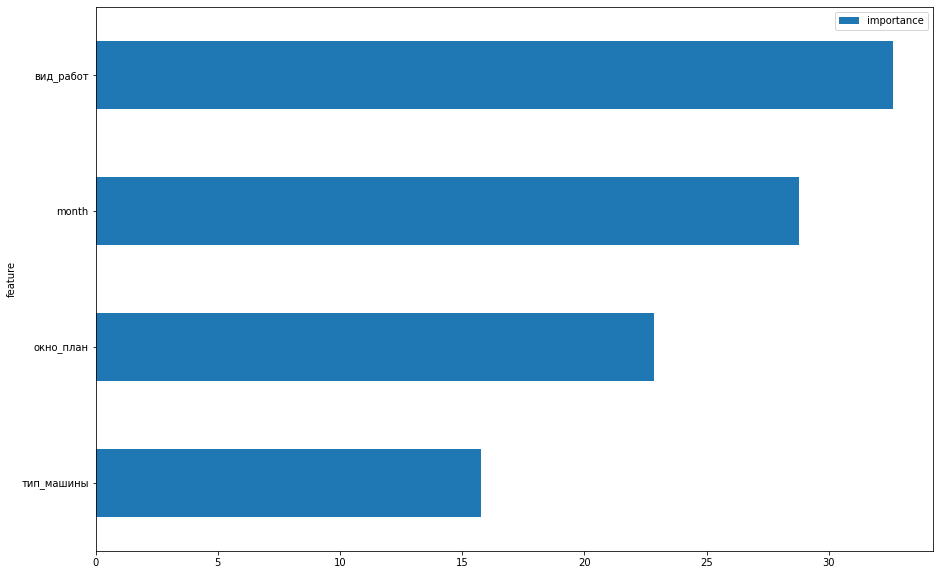

In [658]:
fi = pd.DataFrame({'importance': search_catboost.best_estimator_.feature_importances_, 'feature': search_catboost.best_estimator_.feature_names_}).sort_values(by='importance')
fi.plot(kind='barh', y='importance', x='feature', figsize=(15, 10))
plt.show()

### Part 2

In [18]:
params_catboost_2 = {
    'iterations': np.arange(150, 1001),
    'depth':  np.arange(3, 10),
    'l2_leaf_reg': np.geomspace(1e-3, 1e-1, 100)
}

In [19]:
search_catboost_2 = RandomizedSearchCV(
    catboost,
    param_distributions=params_catboost_2,
    n_iter=300,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=True,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [ ]:
search_catboost_2.fit(X_train, y_train, cat_features=[0, 1, 2], verbose=0)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.1min


In [22]:
pd.DataFrame(search_catboost_2.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_leaf_reg,param_iterations,param_depth,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
9,7.964389,0.138621,0.040010,0.017473,0.00114976,200,5,"{'l2_leaf_reg': 0.0011497569953977356, 'iterat...",-108.258334,-105.724442,...,-112.993835,6.048522,1,-111.340217,-112.052671,-116.270721,-109.120811,-108.788027,-111.514490,2.687193
60,7.629914,0.029198,0.021805,0.011637,0.0911163,156,7,"{'l2_leaf_reg': 0.09111627561154896, 'iteratio...",-110.005523,-106.240256,...,-113.323312,6.014358,2,-112.403771,-112.966100,-111.067451,-107.825862,-107.890685,-110.430774,2.189227
3,7.884175,0.171471,0.032003,0.013933,0.0376494,188,6,"{'l2_leaf_reg': 0.037649358067924694, 'iterati...",-108.374079,-107.157943,...,-113.369371,6.030989,3,-112.420872,-113.375033,-114.378521,-108.349809,-109.348864,-111.574620,2.331218
24,7.849564,0.122987,0.045809,0.012403,0.0830218,184,6,"{'l2_leaf_reg': 0.08302175681319748, 'iteratio...",-108.169487,-107.254540,...,-113.389450,6.004723,4,-111.906773,-113.550802,-114.008236,-108.325317,-109.354195,-111.429065,2.250353
183,7.001573,0.041785,0.031407,0.005084,0.0033516,171,6,"{'l2_leaf_reg': 0.003351602650938841, 'iterati...",-108.474294,-107.234038,...,-113.497337,6.067898,5,-112.404094,-113.666737,-114.514397,-108.742206,-109.424190,-111.750325,2.289097
184,8.216645,0.151767,0.039009,0.008416,0.0628029,225,5,"{'l2_leaf_reg': 0.06280291441834256, 'iteratio...",-108.255989,-106.332367,...,-113.498052,6.338495,6,-111.680443,-112.406305,-116.577074,-109.986789,-109.167488,-111.963620,2.580168
258,7.125601,0.180207,0.032206,0.019908,0.0572237,163,6,"{'l2_leaf_reg': 0.0572236765935022, 'iteration...",-108.545975,-107.058707,...,-113.501937,6.061661,7,-112.145077,-113.552438,-114.671428,-108.754606,-109.579095,-111.740529,2.263819
55,7.389859,0.145165,0.038209,0.011722,0.00145083,162,6,"{'l2_leaf_reg': 0.0014508287784959402, 'iterat...",-108.579025,-107.081870,...,-113.514413,6.027668,8,-112.450042,-113.587521,-114.703396,-108.773853,-109.624731,-111.827909,2.277409
44,7.569500,0.156656,0.033408,0.017273,0.00642807,165,6,"{'l2_leaf_reg': 0.006428073117284319, 'iterati...",-108.621364,-107.229855,...,-113.574942,6.047357,9,-112.499816,-113.753380,-114.685575,-108.820103,-109.516803,-111.855135,2.311257
281,8.628338,0.112168,0.032408,0.015216,0.0312572,230,5,"{'l2_leaf_reg': 0.03125715849688237, 'iteratio...",-108.394155,-106.578792,...,-113.628632,6.265544,10,-111.820681,-112.588875,-116.649334,-110.010144,-109.321970,-112.078201,2.572782


### Part 3

In [18]:
params_catboost_3 = {
    'iterations': [200],
    'depth':  np.arange(3, 10),
    'l2_leaf_reg': np.geomspace(1e-3, 1e-1, 100)
}

In [19]:
search_catboost_2 = RandomizedSearchCV(
    catboost,
    param_distributions=params_catboost_2,
    n_iter=300,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=True,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [ ]:
search_catboost_2.fit(X_train, y_train, cat_features=[0, 1, 2], verbose=0)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.1min


In [184]:
y_train_log[y_train_log == 0]

14268    0.0
6083     0.0
6084     0.0
14475    0.0
9900     0.0
11328    0.0
12648    0.0
11327    0.0
2459     0.0
10167    0.0
6062     0.0
11330    0.0
9262     0.0
15460    0.0
15373    0.0
Name: Удельный расход топлива, dtype: float64

In [22]:
pd.DataFrame(search_catboost_2.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_l2_leaf_reg,param_iterations,param_depth,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
9,7.964389,0.138621,0.040010,0.017473,0.00114976,200,5,"{'l2_leaf_reg': 0.0011497569953977356, 'iterat...",-108.258334,-105.724442,...,-112.993835,6.048522,1,-111.340217,-112.052671,-116.270721,-109.120811,-108.788027,-111.514490,2.687193
60,7.629914,0.029198,0.021805,0.011637,0.0911163,156,7,"{'l2_leaf_reg': 0.09111627561154896, 'iteratio...",-110.005523,-106.240256,...,-113.323312,6.014358,2,-112.403771,-112.966100,-111.067451,-107.825862,-107.890685,-110.430774,2.189227
3,7.884175,0.171471,0.032003,0.013933,0.0376494,188,6,"{'l2_leaf_reg': 0.037649358067924694, 'iterati...",-108.374079,-107.157943,...,-113.369371,6.030989,3,-112.420872,-113.375033,-114.378521,-108.349809,-109.348864,-111.574620,2.331218
24,7.849564,0.122987,0.045809,0.012403,0.0830218,184,6,"{'l2_leaf_reg': 0.08302175681319748, 'iteratio...",-108.169487,-107.254540,...,-113.389450,6.004723,4,-111.906773,-113.550802,-114.008236,-108.325317,-109.354195,-111.429065,2.250353
183,7.001573,0.041785,0.031407,0.005084,0.0033516,171,6,"{'l2_leaf_reg': 0.003351602650938841, 'iterati...",-108.474294,-107.234038,...,-113.497337,6.067898,5,-112.404094,-113.666737,-114.514397,-108.742206,-109.424190,-111.750325,2.289097
184,8.216645,0.151767,0.039009,0.008416,0.0628029,225,5,"{'l2_leaf_reg': 0.06280291441834256, 'iteratio...",-108.255989,-106.332367,...,-113.498052,6.338495,6,-111.680443,-112.406305,-116.577074,-109.986789,-109.167488,-111.963620,2.580168
258,7.125601,0.180207,0.032206,0.019908,0.0572237,163,6,"{'l2_leaf_reg': 0.0572236765935022, 'iteration...",-108.545975,-107.058707,...,-113.501937,6.061661,7,-112.145077,-113.552438,-114.671428,-108.754606,-109.579095,-111.740529,2.263819
55,7.389859,0.145165,0.038209,0.011722,0.00145083,162,6,"{'l2_leaf_reg': 0.0014508287784959402, 'iterat...",-108.579025,-107.081870,...,-113.514413,6.027668,8,-112.450042,-113.587521,-114.703396,-108.773853,-109.624731,-111.827909,2.277409
44,7.569500,0.156656,0.033408,0.017273,0.00642807,165,6,"{'l2_leaf_reg': 0.006428073117284319, 'iterati...",-108.621364,-107.229855,...,-113.574942,6.047357,9,-112.499816,-113.753380,-114.685575,-108.820103,-109.516803,-111.855135,2.311257
281,8.628338,0.112168,0.032408,0.015216,0.0312572,230,5,"{'l2_leaf_reg': 0.03125715849688237, 'iteratio...",-108.394155,-106.578792,...,-113.628632,6.265544,10,-111.820681,-112.588875,-116.649334,-110.010144,-109.321970,-112.078201,2.572782


## Линейная регрессия

In [50]:
# data preprocessing - Standard Scale for numeric features and OHE for categorical features
ct = ColumnTransformer([
#     ('numerical', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include='category'))
], remainder='passthrough')

In [51]:
pipe_logreg = Pipeline([
    ('transformer', ct),
    ('regression', LinearRegression())
])

In [52]:
params_logreg = {
    'regression__n_jobs': [1]
}

In [53]:
search_logreg = GridSearchCV(
    pipe_logreg,
    param_grid=params_logreg,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=True,
    verbose=5,
    return_train_score=True
)

In [54]:
search_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC183BCFA0>)])),
                                       ('regression', LinearRegression())]),
             n_jobs=-1, param_grid={'regression__n_jobs': [1]},
             return_train_score=True,
             scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
             verbose=5)

In [55]:
pd.DataFrame(search_logreg.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression__n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.041409,0.002333,0.008002,2.431402e-07,1,{'regression__n_jobs': 1},-2243.035972,-1804.173621,-1917.503971,-2508.616876,...,-2156.575327,259.287816,1,-1899.82009,-2052.792727,-2107.570809,-2166.248137,-2124.317116,-2070.149776,92.609717


## LightGBM

In [19]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder

In [39]:
# data preprocessing - Standard Scale for numeric features and OHE for categorical features
ct = ColumnTransformer([
    ('categorical', OrdinalEncoder(dtype=np.int32), make_column_selector(dtype_include='category'))
], remainder='passthrough')

In [40]:
X_train_ordinal = ct.fit_transform(X_train)

In [41]:
lgbm = LGBMRegressor(objective='mape', random_state=42, n_jobs=1)

## Part 1

In [222]:
params_lgbm = {
    'learning_rate': np.geomspace(1e-3, 1, 100),
    'n_estimators': np.arange(1, 5001),
    'max_depth': np.concatenate((np.arange(1, 16), np.arange(-1, 0))),
    'num_leaves': np.arange(2, 61)
}

In [223]:
search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distributions=params_lgbm,
    n_iter=100,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=False,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [224]:
search_lgbm.fit(X_train_ordinal, y_train, categorical_feature=[0, 1, 2])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.1min finished


RandomizedSearchCV(estimator=LGBMRegressor(n_jobs=1, objective='mape',
                                           random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.0035...
                                        'n_estimators': array([   1,    2,    3, ..., 4998, 4999, 5000]),
                                        'num_leaves': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60])},
                   random_state=42, refit=False, return_train_score=True,
              

In [134]:
pd.DataFrame(search_lgbm.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
23,6.314033,0.181871,1.454762,0.184687,57,1387,14,0.053367,"{'num_leaves': 57, 'n_estimators': 1387, 'max_...",-65.999613,...,-65.917252,3.879729,1,-55.924886,-54.770106,-55.607204,-53.527667,-54.473861,-54.860745,0.851421
44,4.095692,0.194786,0.795779,0.137896,56,957,-1,0.107227,"{'num_leaves': 56, 'n_estimators': 957, 'max_d...",-67.045604,...,-67.809835,4.589811,2,-54.723937,-55.404873,-55.957337,-54.463266,-53.560564,-54.821995,0.819544
32,15.176598,0.262322,6.337034,0.362750,51,3854,-1,0.00403702,"{'num_leaves': 51, 'n_estimators': 3854, 'max_...",-67.831116,...,-68.311652,4.684612,3,-60.246509,-59.797664,-61.151170,-59.517421,-59.982045,-60.138962,0.559205
17,18.474912,0.624908,8.216583,0.444855,46,4579,9,0.00497702,"{'num_leaves': 46, 'n_estimators': 4579, 'max_...",-67.754822,...,-68.549500,4.174536,4,-60.171885,-59.383297,-60.776695,-58.557298,-61.083161,-59.994467,0.923861
67,8.056788,0.165264,2.261540,0.346300,55,1931,15,0.0403702,"{'num_leaves': 55, 'n_estimators': 1931, 'max_...",-66.169152,...,-68.758676,5.286754,5,-55.456663,-55.315091,-56.116732,-53.504156,-54.056573,-54.889843,0.961441
54,4.431682,0.092421,0.739581,0.120366,53,1048,12,0.114976,"{'num_leaves': 53, 'n_estimators': 1048, 'max_...",-66.720226,...,-68.797176,4.004113,6,-54.346110,-54.468080,-55.315875,-53.980973,-53.603398,-54.342887,0.572750
11,13.726838,0.132084,5.039467,0.929888,49,3258,14,0.0376494,"{'num_leaves': 49, 'n_estimators': 3258, 'max_...",-67.154557,...,-69.142011,4.685446,7,-54.637940,-54.893673,-56.263688,-53.793373,-54.156188,-54.748972,0.847608
33,5.144064,0.079924,1.132371,0.196700,48,1319,9,0.0132194,"{'num_leaves': 48, 'n_estimators': 1319, 'max_...",-68.468309,...,-69.369170,4.169505,8,-60.394846,-59.210611,-61.457946,-59.281578,-60.516988,-60.172394,0.841362
75,18.030125,0.376916,6.406430,0.384888,60,4148,-1,0.00162975,"{'num_leaves': 60, 'n_estimators': 4148, 'max_...",-69.263537,...,-69.618127,4.338942,9,-63.197410,-62.439909,-64.108251,-61.743779,-62.387384,-62.775346,0.810178
29,8.939964,0.094803,3.321112,0.642842,57,2171,9,0.00464159,"{'num_leaves': 57, 'n_estimators': 2171, 'max_...",-68.999494,...,-69.679335,5.112785,10,-61.083223,-59.781240,-62.008778,-59.926413,-60.410531,-60.642037,0.820891


In [225]:
pd.DataFrame(search_lgbm.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
82,10.109932,0.150806,3.240115,0.209673,60,2826,8,0.187382,"{'num_leaves': 60, 'n_estimators': 2826, 'max_...",-61.128645,...,-62.139507,4.021712,1,-48.740685,-47.942364,-49.056751,-48.296255,-47.514919,-48.310195,0.549659
99,7.054014,0.291876,1.747555,0.365476,57,1905,9,0.265609,"{'num_leaves': 57, 'n_estimators': 1905, 'max_...",-60.534026,...,-62.433742,4.171360,2,-48.271875,-47.933999,-49.263422,-47.629326,-47.355009,-48.090726,0.661327
84,11.653692,0.230078,3.792900,0.193822,49,3317,10,0.070548,"{'num_leaves': 49, 'n_estimators': 3317, 'max_...",-61.404006,...,-62.908391,4.300770,3,-51.613175,-50.961518,-52.053677,-50.736295,-51.169629,-51.306859,0.472272
59,9.826340,0.274080,3.617505,0.390292,43,2655,8,0.305386,"{'num_leaves': 43, 'n_estimators': 2655, 'max_...",-60.932980,...,-63.227681,4.580062,4,-50.166292,-49.357409,-50.010105,-49.216175,-49.192324,-49.588461,0.414869
85,7.219610,0.212585,1.628757,0.586357,39,2169,8,0.0432876,"{'num_leaves': 39, 'n_estimators': 2169, 'max_...",-62.460381,...,-63.560364,4.146571,5,-55.265898,-55.493234,-55.224402,-53.986665,-54.362951,-54.866630,0.584479
24,11.059107,0.126557,3.265514,0.268239,53,2943,8,0.247708,"{'num_leaves': 53, 'n_estimators': 2943, 'max_...",-60.789306,...,-63.617623,5.186260,6,-48.425945,-48.186120,-48.884829,-48.802863,-47.827523,-48.425456,0.391986
12,10.615319,0.317536,3.093918,0.365489,46,2987,11,0.200923,"{'num_leaves': 46, 'n_estimators': 2987, 'max_...",-61.026266,...,-63.807751,4.524369,7,-51.144961,-50.835375,-51.547032,-51.992585,-49.801613,-51.064313,0.741355
53,12.800062,0.415394,4.708675,0.702116,46,3977,7,0.0174753,"{'num_leaves': 46, 'n_estimators': 3977, 'max_...",-63.411680,...,-63.816752,3.960541,8,-57.087286,-58.455498,-56.242803,-54.866146,-55.490938,-56.428534,1.256756
54,3.865297,0.083804,0.367391,0.057838,53,1048,12,0.114976,"{'num_leaves': 53, 'n_estimators': 1048, 'max_...",-62.353214,...,-63.833181,4.030997,9,-54.100883,-53.532049,-54.537352,-52.598779,-53.315197,-53.616852,0.665773
33,4.660277,0.170159,0.620984,0.120685,48,1319,9,0.0132194,"{'num_leaves': 48, 'n_estimators': 1319, 'max_...",-64.429290,...,-65.115190,4.291876,10,-60.428640,-58.347351,-59.783171,-57.729227,-58.192575,-58.896193,1.028906


## Part 2

In [234]:
params_lgbm_2 = {
    'learning_rate': np.geomspace(1e-3, 1, 100),
    'n_estimators': np.arange(1, 5001),
    'max_depth': np.concatenate((np.arange(1, 16), np.arange(-1, 0))),
    'num_leaves': np.arange(35, 101)
}

In [235]:
search_lgbm_2 = RandomizedSearchCV(
    lgbm,
    param_distributions=params_lgbm_2,
    n_iter=100,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=False,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [236]:
search_lgbm_2.fit(X_train_ordinal, y_train, categorical_feature=[0, 1, 2])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.0min finished


RandomizedSearchCV(estimator=LGBMRegressor(n_jobs=1, objective='mape',
                                           random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.0035...
                                        'num_leaves': array([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100])},
                   random_state=42, refit=False, return_train_score=True,
            

In [237]:
pd.DataFrame(search_lgbm_2.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
66,13.681638,0.375340,4.195490,0.517221,85,3172,11,0.0432876,"{'num_leaves': 85, 'n_estimators': 3172, 'max_...",-60.333553,...,-61.165074,3.943793,1,-49.210505,-48.480052,-49.817588,-48.094345,-48.231135,-48.766725,0.651519
17,4.154890,0.082685,0.698981,0.032434,88,970,10,0.107227,"{'num_leaves': 88, 'n_estimators': 970, 'max_d...",-59.949667,...,-61.236839,3.933197,2,-49.327225,-49.260814,-49.722701,-48.439874,-48.278955,-49.005914,0.553330
82,16.661960,0.244918,5.970243,0.440301,86,3931,11,0.107227,"{'num_leaves': 86, 'n_estimators': 3931, 'max_...",-59.075938,...,-61.388673,4.324614,3,-45.912897,-45.886159,-46.935242,-46.308809,-45.607511,-46.130123,0.460429
1,8.610172,0.288406,2.459735,0.152108,79,2129,10,0.070548,"{'num_leaves': 79, 'n_estimators': 2129, 'max_...",-59.690304,...,-61.439795,4.023830,4,-48.921639,-48.925114,-50.481364,-48.660393,-47.774101,-48.952522,0.873279
0,16.701958,0.406338,5.877045,0.115654,94,3797,14,0.0132194,"{'num_leaves': 94, 'n_estimators': 3797, 'max_...",-60.619164,...,-61.489429,4.141932,5,-51.539479,-50.499682,-51.590782,-50.185681,-50.032268,-50.769578,0.667012
92,17.207344,0.143161,5.420057,0.075841,92,3907,13,0.0162975,"{'num_leaves': 92, 'n_estimators': 3907, 'max_...",-60.375346,...,-61.539470,3.929131,6,-51.001141,-49.975297,-50.984169,-49.407494,-50.135166,-50.300653,0.614630
48,4.989869,0.145655,0.889177,0.150561,70,1238,12,0.162975,"{'num_leaves': 70, 'n_estimators': 1238, 'max_...",-60.216447,...,-61.644770,4.031927,7,-49.728538,-48.785889,-50.276029,-48.802366,-48.721601,-49.262885,0.628631
30,0.633383,0.026188,0.057798,0.002482,93,140,10,0.756463,"{'num_leaves': 93, 'n_estimators': 140, 'max_d...",-59.623345,...,-61.718114,3.994681,8,-47.237096,-48.076063,-48.263474,-46.978770,-47.217074,-47.554495,0.513953
12,9.877140,0.138488,3.669904,0.128444,65,2519,9,0.114976,"{'num_leaves': 65, 'n_estimators': 2519, 'max_...",-60.419682,...,-61.725169,4.440062,9,-48.492749,-48.351280,-50.062054,-48.666299,-48.115407,-48.737558,0.686379
94,8.663171,0.075249,2.657730,0.515381,68,2451,8,0.107227,"{'num_leaves': 68, 'n_estimators': 2451, 'max_...",-60.544578,...,-61.758368,3.830847,10,-49.958447,-49.673329,-50.193840,-49.221040,-49.327440,-49.674819,0.367809


## Part 3

In [242]:
params_lgbm_3 = {
    'learning_rate': np.geomspace(1e-3, 1, 100),
    'n_estimators': np.arange(1, 5001),
    'max_depth': np.concatenate((np.arange(7, 21), np.arange(-1, 0))),
    'num_leaves': np.arange(75, 151)
}

In [243]:
search_lgbm_3 = RandomizedSearchCV(
    lgbm,
    param_distributions=params_lgbm_3,
    n_iter=100,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=False,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [244]:
search_lgbm_3.fit(X_train_ordinal, y_train, categorical_feature=[0, 1, 2])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 31.4min finished


RandomizedSearchCV(estimator=LGBMRegressor(n_jobs=1, objective='mape',
                                           random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.0035...
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150])},
                   random_state=42, refit=False, return_train_score=True,
                   scoring=make_scorer(mean_absolute_percentage_error, greater_is_better

In [245]:
pd.DataFrame(search_lgbm_3.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
31,13.010046,0.183415,4.532261,0.136719,118,2600,16,0.123285,"{'num_leaves': 118, 'n_estimators': 2600, 'max...",-58.287540,...,-60.765056,3.550677,1,-44.829649,-44.652897,-45.131412,-45.340439,-44.048717,-44.800623,0.444714
65,20.819569,0.374147,9.302925,0.115523,107,4672,11,0.0613591,"{'num_leaves': 107, 'n_estimators': 4672, 'max...",-58.898936,...,-60.872603,4.122861,2,-45.721401,-45.295776,-46.602153,-45.991273,-45.607931,-45.843707,0.439953
44,7.364345,0.158543,1.805413,0.287562,110,1572,17,0.0756463,"{'num_leaves': 110, 'n_estimators': 1572, 'max...",-59.265841,...,-60.882279,4.034125,3,-47.505733,-47.301288,-48.688421,-47.211146,-46.836045,-47.508527,0.628613
57,4.642649,0.032181,0.959980,0.278300,114,953,17,0.1,"{'num_leaves': 114, 'n_estimators': 953, 'max_...",-59.573902,...,-61.042599,4.072595,4,-47.811333,-47.300274,-48.232730,-46.863198,-47.203287,-47.482165,0.482841
4,17.743417,0.265680,6.322619,0.126231,135,3267,-1,0.151991,"{'num_leaves': 135, 'n_estimators': 3267, 'max...",-58.834362,...,-61.114286,3.871445,5,-43.751120,-43.156411,-44.028382,-43.826996,-42.816460,-43.515874,0.454576
55,12.951001,0.375732,4.750953,0.280224,128,2595,18,0.162975,"{'num_leaves': 128, 'n_estimators': 2595, 'max...",-58.048033,...,-61.118555,4.042211,6,-43.605007,-43.453853,-44.464351,-44.189130,-43.341216,-43.810711,0.438300
91,10.527325,0.302706,3.411203,0.395128,143,1886,20,0.141747,"{'num_leaves': 143, 'n_estimators': 1886, 'max...",-58.592427,...,-61.179288,3.566135,7,-44.330003,-43.690798,-45.685555,-44.360095,-44.017638,-44.416818,0.679249
88,17.316277,0.755107,6.332833,0.898977,131,3453,12,0.187382,"{'num_leaves': 131, 'n_estimators': 3453, 'max...",-58.463701,...,-61.187088,4.564512,8,-43.351767,-43.396464,-43.497285,-43.375131,-42.605178,-43.245165,0.323819
66,10.865430,0.280589,2.878726,0.197680,86,2546,12,0.0932603,"{'num_leaves': 86, 'n_estimators': 2546, 'max_...",-59.056197,...,-61.189026,4.510507,9,-47.043802,-46.937927,-48.119829,-47.402841,-46.900889,-47.281058,0.455395
95,19.603432,0.172979,6.433365,0.258645,122,3815,16,0.0497702,"{'num_leaves': 122, 'n_estimators': 3815, 'max...",-60.353097,...,-61.243506,3.916955,10,-46.498489,-45.543831,-46.654855,-46.240649,-45.179409,-46.023447,0.568146


## Part 4

In [263]:
params_lgbm_4 = {
    'learning_rate': np.geomspace(1e-3, 1, 500),
    'n_estimators': np.arange(1, 5001),
    'max_depth': np.concatenate((np.arange(9, 26), np.arange(-1, 0))),
    'num_leaves': np.arange(100, 141)
}

In [264]:
search_lgbm_4 = RandomizedSearchCV(
    lgbm,
    param_distributions=params_lgbm_4,
    n_iter=100,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=False,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [265]:
search_lgbm_4.fit(X_train_ordinal, y_train, categorical_feature=[0, 1, 2])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 31.5min finished


RandomizedSearchCV(estimator=LGBMRegressor(n_jobs=1, objective='mape',
                                           random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.00101394, 0.00102807, 0.0010424 , 0.00105693,
       0.00107167, 0.00108661, 0.00110175, 0.00111711, 0.00113268,
       0.00114847, 0.00116448, 0.00118071, 0.00119717, 0.00121386,
       0.00123078, 0.00124794, 0.00126533, 0.00128...
                                        'n_estimators': array([   1,    2,    3, ..., 4998, 4999, 5000]),
                                        'num_leaves': array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140])},
                   random_state=42, refit=False, return_train_score=True,
                   scoring=make_scorer(mean_

In [266]:
pd.DataFrame(search_lgbm_4.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
41,17.415818,0.620795,6.021181,0.290452,109,3694,25,0.0977192,"{'num_leaves': 109, 'n_estimators': 3694, 'max...",-58.614394,...,-60.602954,4.001331,1,-45.567838,-45.302638,-45.503048,-45.434528,-44.993936,-45.360398,0.203227
55,6.408719,0.133788,1.600701,0.153980,133,1257,-1,0.142005,"{'num_leaves': 133, 'n_estimators': 1257, 'max...",-58.690543,...,-60.711904,3.821907,2,-45.477919,-45.010363,-45.617231,-44.938608,-44.626910,-45.134206,0.363977
4,19.891009,0.432339,7.069554,0.462152,113,4115,18,0.0899307,"{'num_leaves': 113, 'n_estimators': 4115, 'max...",-58.891165,...,-60.801716,3.927247,3,-45.375292,-44.849995,-45.137637,-45.586304,-44.147061,-45.019258,0.500339
62,17.186661,0.606383,6.379664,0.851158,112,3696,18,0.0482355,"{'num_leaves': 112, 'n_estimators': 3696, 'max...",-58.687612,...,-60.906184,4.022372,4,-46.744229,-46.560714,-47.448140,-46.647096,-46.356572,-46.751350,0.371114
60,11.820736,0.408547,3.905845,0.382677,118,2352,22,0.0408529,"{'num_leaves': 118, 'n_estimators': 2352, 'max...",-59.506548,...,-60.923404,3.927666,5,-47.936099,-47.624824,-48.975223,-47.079644,-46.965710,-47.716300,0.722535
31,14.468570,0.224934,5.239605,0.374696,137,2796,-1,0.107662,"{'num_leaves': 137, 'n_estimators': 2796, 'max...",-58.971657,...,-60.960316,3.787504,6,-44.488236,-44.130541,-44.578528,-44.642824,-43.877848,-44.343595,0.292563
83,5.263965,0.104841,0.880579,0.158302,101,1145,16,0.24705,"{'num_leaves': 101, 'n_estimators': 1145, 'max...",-59.223585,...,-60.980884,3.861033,7,-45.508155,-45.936273,-46.520040,-45.853063,-44.910637,-45.745634,0.529378
71,17.027539,0.234124,6.632087,0.895138,121,3575,12,0.0645088,"{'num_leaves': 121, 'n_estimators': 3575, 'max...",-58.741455,...,-60.991585,4.173078,8,-45.507887,-45.092913,-46.496837,-45.580880,-45.345818,-45.604867,0.476402
39,19.654079,0.288290,7.196677,0.454564,123,4032,25,0.0419997,"{'num_leaves': 123, 'n_estimators': 4032, 'max...",-59.327823,...,-61.004890,3.850338,9,-46.505276,-46.142207,-46.779219,-46.078081,-45.752351,-46.251427,0.356106
26,4.518619,0.215710,0.981235,0.182263,108,988,11,0.134356,"{'num_leaves': 108, 'n_estimators': 988, 'max_...",-59.871363,...,-61.021690,3.937904,10,-47.177867,-46.555323,-48.235797,-46.530513,-46.019540,-46.903808,0.760529


## Part 5

In [380]:
50 * 100 * 51 * 150 * 50 < 2147483647

True

In [23]:
params_lgbm_5 = {
    'learning_rate': np.geomspace(1e-3, 1, 50),
    'n_estimators': np.arange(1, 5001, 100),
    'max_depth': np.concatenate((np.arange(1, 51), np.arange(-1, 0))),
    'num_leaves': np.arange(1, 151),
    'reg_lambda': np.geomspace(1e-2, 1e2, 50)
}

In [24]:
search_lgbm_5 = RandomizedSearchCV(
    lgbm,
    param_distributions=params_lgbm_5,
    n_iter=100,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=False,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [25]:
search_lgbm_5.fit(X_train_ordinal, y_train, categorical_feature=[0, 1, 2])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 27.3min finished


RandomizedSearchCV(estimator=LGBMRegressor(n_jobs=1, objective='mape',
                                           random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.012648...
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02])},
                   random_state=42, refit=False, return_train_score=True,
                   scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                   verbose=5)

In [26]:
pd.DataFrame(search_lgbm_5.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_lambda,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
73,18.647508,0.432870,5.695053,0.171428,0.13895,105,3601,21,0.0449843,"{'reg_lambda': 0.13894954943731375, 'num_leave...",...,-60.831117,3.954684,1,-47.186126,-47.054049,-48.232261,-47.454500,-46.444974,-47.274382,0.582104
40,18.991499,0.600887,6.729824,0.274469,1.59986,132,3201,17,0.0790604,"{'reg_lambda': 1.5998587196060574, 'num_leaves...",...,-60.956483,3.996026,2,-44.596496,-44.484900,-45.582950,-45.504607,-44.459457,-44.925682,0.507380
78,18.435714,0.434374,6.061240,0.448025,0.244205,119,3601,40,0.13895,"{'reg_lambda': 0.2442053094548651, 'num_leaves...",...,-61.266557,4.193510,3,-43.742165,-43.745138,-44.419813,-44.173293,-43.451955,-43.906473,0.344767
99,8.038189,0.800386,2.634130,1.128565,7.19686,131,1501,35,0.244205,"{'reg_lambda': 7.196856730011514, 'num_leaves'...",...,-61.378161,4.666700,4,-43.619232,-43.264725,-44.126419,-43.884800,-42.900028,-43.559041,0.436481
49,2.875524,0.095248,0.354190,0.028658,0.167683,149,501,39,0.0596362,"{'reg_lambda': 0.16768329368110074, 'num_leave...",...,-61.404645,3.881437,5,-49.583435,-48.647104,-49.630834,-48.398528,-47.995882,-48.851157,0.651480
66,29.992407,2.233038,10.088334,0.937404,0.167683,140,4701,21,0.0686649,"{'reg_lambda': 0.16768329368110074, 'num_leave...",...,-61.442215,3.564286,6,-44.794837,-43.958678,-44.917272,-44.023111,-44.142395,-44.367259,0.405284
39,9.942137,1.175889,3.697903,0.117002,82.8643,110,1901,34,0.104811,"{'reg_lambda': 82.86427728546842, 'num_leaves'...",...,-61.503981,3.923280,7,-46.527757,-46.504974,-46.577039,-45.899917,-45.792236,-46.260385,0.340788
45,23.348583,4.137801,7.857995,1.613632,1.59986,134,3601,18,0.0167683,"{'reg_lambda': 1.5998587196060574, 'num_leaves...",...,-61.512235,4.113641,8,-48.628703,-47.731573,-48.850484,-47.499621,-47.321009,-48.006278,0.616742
54,4.126890,0.195718,0.746581,0.103590,8.68511,109,801,36,0.0294705,"{'reg_lambda': 8.68511373751352, 'num_leaves':...",...,-61.550226,4.050752,9,-51.802470,-50.894259,-51.414519,-50.253194,-49.934594,-50.859807,0.695917
75,18.301916,0.532628,6.659425,0.413132,3.39322,89,4201,35,0.0126486,"{'reg_lambda': 3.3932217718953264, 'num_leaves...",...,-61.580149,4.217561,10,-51.411554,-50.619571,-51.540526,-50.028113,-49.720150,-50.663983,0.724474


## Part 6

In [49]:
params_lgbm_6 = {
    'learning_rate': np.geomspace(1e-3, 1, 200),
    'n_estimators': np.arange(1, 5001, 10),
    'max_depth': np.concatenate((np.arange(1, 51), np.arange(-1, 0))),
    'num_leaves': np.arange(2, 151)
}

In [50]:
search_lgbm_6 = RandomizedSearchCV(
    lgbm,
    param_distributions=params_lgbm_6,
    n_iter=100,
    scoring=mape_scorer,
    n_jobs=-1,
    refit=False,
    verbose=5,
    return_train_score=True,
    random_state=42
)

In [51]:
search_lgbm_6.fit(X_train_ordinal, y_train, categorical_feature=[0, 1, 2, 5])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 35.3min finished


RandomizedSearchCV(estimator=LGBMRegressor(n_jobs=1, objective='mape',
                                           random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.001     , 0.00103532, 0.00107189, 0.00110975, 0.00114895,
       0.00118953, 0.00123155, 0.00127505, 0.00132009, 0.00136672,
       0.00141499, 0.00146497, 0.00151672, 0.00157029, 0.00162576,
       0.00168318, 0.00174263, 0.00180419, 0.0018...
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150])},
                   random_state=42, refit=False, return_train_score=True,
                   scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
                

In [52]:
pd.DataFrame(search_lgbm_6.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
10,20.896208,1.723115,9.416660,0.675770,74,4241,32,0.0261268,"{'num_leaves': 74, 'n_estimators': 4241, 'max_...",-64.137902,...,-65.363596,5.121208,1,-50.561688,-50.747491,-50.960867,-50.127323,-50.213063,-50.522086,0.315036
85,12.941648,1.167286,5.094970,1.080202,137,1941,35,0.0644236,"{'num_leaves': 137, 'n_estimators': 1941, 'max...",-64.722330,...,-65.392291,4.403344,2,-47.349894,-46.850754,-48.229066,-46.641477,-47.529692,-47.320177,0.557109
42,8.394102,0.852053,2.392283,0.614034,102,1301,28,0.0126038,"{'num_leaves': 102, 'n_estimators': 1301, 'max...",-68.600666,...,-65.782983,4.712721,3,-53.521899,-52.986851,-54.950258,-52.586981,-52.838505,-53.376899,0.844092
88,14.281805,0.396596,5.326714,0.512507,127,2261,14,0.00529198,"{'num_leaves': 127, 'n_estimators': 2261, 'max...",-63.914642,...,-65.905717,5.158323,4,-54.104466,-53.518530,-54.465770,-52.910802,-53.219331,-53.643780,0.569386
91,22.838878,1.203192,8.284272,0.774275,144,3461,16,0.00608022,"{'num_leaves': 144, 'n_estimators': 3461, 'max...",-63.502617,...,-66.022273,4.629943,5,-51.997774,-51.692909,-52.576043,-50.875069,-50.942460,-51.616851,0.644357
89,27.257151,1.242475,11.224316,1.001546,129,4331,20,0.00273644,"{'num_leaves': 129, 'n_estimators': 4331, 'max...",-63.821069,...,-66.195670,4.012837,6,-54.040542,-53.169814,-54.627512,-53.176406,-52.704517,-53.543758,0.692882
53,17.360071,0.842865,6.599298,0.282120,142,2581,45,0.00373994,"{'num_leaves': 142, 'n_estimators': 2581, 'max...",-66.456680,...,-66.350509,4.805286,7,-54.558996,-54.214855,-56.611637,-54.077024,-53.506282,-54.593759,1.064540
82,8.139931,0.144471,3.003180,0.321699,136,1361,45,0.00460592,"{'num_leaves': 136, 'n_estimators': 1361, 'max...",-64.651915,...,-66.355422,5.348379,8,-57.597673,-57.041814,-58.144621,-56.422647,-55.743659,-56.990083,0.846210
66,8.017755,0.337864,2.561437,0.184405,117,1341,17,0.0369691,"{'num_leaves': 117, 'n_estimators': 1341, 'max...",-65.674689,...,-66.396156,5.289786,9,-50.564671,-49.291960,-50.529897,-50.528006,-49.008366,-49.984580,0.687300
11,11.334556,0.734334,4.090200,0.898375,137,1681,16,0.052311,"{'num_leaves': 137, 'n_estimators': 1681, 'max...",-63.823183,...,-66.453992,4.749397,10,-48.081721,-47.805014,-48.889393,-47.206600,-47.487652,-47.894076,0.578205


# Final model

In [548]:
final_model = CatBoostRegressor(iterations=200, depth=5, l2_leaf_reg=0.00114976, loss_function='MAPE', random_state=42)

In [549]:
final_model.fit(X_train, y_train, cat_features=[0, 1, 2, 5], verbose=0)

In [550]:
final_model.save_model('best_model_v7.cbm')

In [267]:
X_train_ordinal = ct.fit_transform(X_train)
X_test_ordinal = ct.transform(X_test)

In [268]:
final_model = LGBMRegressor(objective='mape', num_leaves=109, n_estimators=3694, max_depth=25, learning_rate=0.0977192, random_state=42)

In [269]:
final_model.fit(X_train_ordinal, y_train, categorical_feature=[0, 1, 2])

D:\Documents\Jupyter Lab\rzdhack\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMRegressor(learning_rate=0.0977192, max_depth=25, n_estimators=3694,
              num_leaves=109, objective='mape', random_state=42)

In [272]:
final_model.booster_.save_model('best_model_v10.mdl')

In [159]:
mean_absolute_percentage_error(y_true=y_test, y_pred=np.power(10, final_model.predict(X_test_ordinal)))

67.89145556501752

In [250]:
mean_absolute_percentage_error(y_true=y_test, y_pred=final_model.predict(X_test))

58.19138332768852

In [270]:
mean_absolute_percentage_error(y_true=y_test, y_pred=final_model.predict(X_test))

58.00747954535481

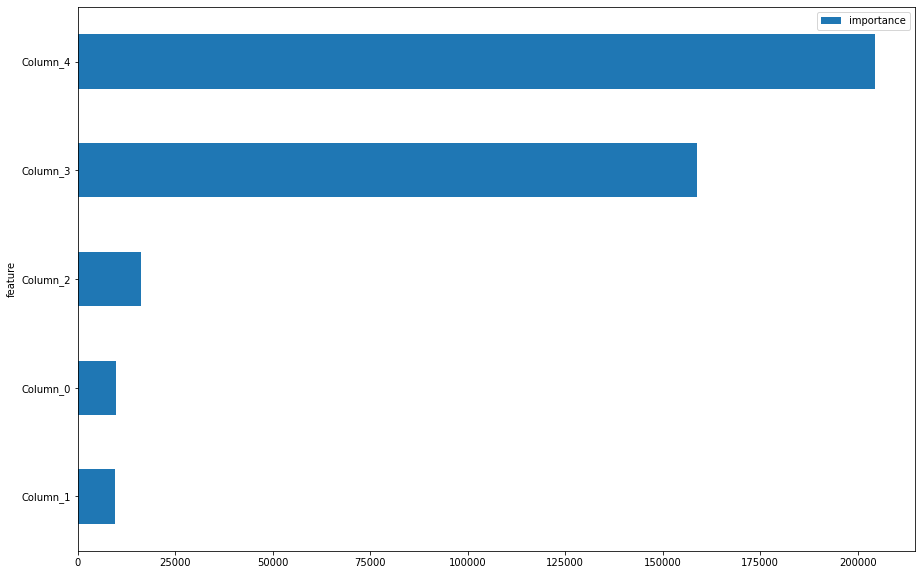

In [271]:
fi = pd.DataFrame({'importance': final_model.feature_importances_, 'feature': final_model.feature_name_}).sort_values(by='importance')
fi.plot(kind='barh', y='importance', x='feature', figsize=(15, 10))
plt.show()

In [ ]:
final_model.f

In [29]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [30]:
test.to_excel('test_merged.xlsx')

# From file

In [275]:
from lightgbm import Booster
from joblib import load, dump

In [278]:
dump(ct, 'ct3.joblib')

['ct3.joblib']

In [279]:
def predict_data(path_to_file='test_merged.xlsx', path_to_model='best_model_v5.mdl'):
    # подгружаем модель
    from_file = Booster(model_file=path_to_model)
#     from_file = CatBoostRegressor()
#     from_file.load_model(path_to_model)
    
    # подгружаем тестовые данные
    data_test = pd.read_excel(path_to_file, index_col=0)
    
    # предобрабатываем тестовые данные
    data_test['month'] = data_test['Дата'].dt.month
    data_test['Вид работ'] = data_test['Вид работ'].astype('category')
    data_test['Тип машины'] = data_test['Тип машины'].astype('category')
    data_test['month'] = data_test['month'].astype('category')
#     data_test['Вып. объем физич. eд.'] = data_test['Вып. объем физич. eд.'].astype('category')
    
    
    # делим на признаки и целевой признак
#     features = data_test[['Вид работ', 'Тип машины', 'month', 'Продолжительность ОКНА план', 'Вып. объем физич.', 'Вып. объем физич. eд.']]
    features = data_test[['Вид работ', 'Тип машины', 'month', 'Продолжительность ОКНА план', 'Вып. объем физич.']]
    target = data_test['Удельный расход топлива']
    
    # предсказываем
    data_test['Предсказание модели'] = from_file.predict(load('ct3.joblib').transform(features))
#     data_test['Предсказание модели'] = from_file.predict(features)
    
    data_test['Разница (%)'] = abs((data_test['Удельный расход топлива'] - data_test['Предсказание модели']) / data_test['Удельный расход топлива']) * 100

    # дропаем ненужные данные
    data_test.drop(columns=['month'], inplace=True)
    
    print(mean_absolute_percentage_error(y_true=data_test['Удельный расход топлива'], y_pred=data_test['Предсказание модели'].values))

    # сохраняем в excel
    data_test.to_excel('predicted_test.xlsx')
    
    pred_true_pivot = data_test.pivot_table(values=['Удельный расход топлива', 'Предсказание модели', 'Разница (%)'], index=['Тип машины', 'Вид работ'], aggfunc='mean')[['Удельный расход топлива', 'Предсказание модели', 'Разница (%)']]
    
    pred_true_pivot.to_excel('pred_true_pivot.xlsx')

In [280]:
predict_data(path_to_model='best_model_v10.mdl')

58.00747954535481


In [846]:
pred = pd.read_excel('predicted_test.xlsx', index_col=0)

In [774]:
pred.pivot_table(values=['удельный_расход_факт', 'предсказание_модели', 'разница_предсказание_%'], index=['тип_машины', 'вид_работ'], aggfunc='mean')[['удельный_расход_факт', 'предсказание_модели', 'разница_предсказание']]

удельный_расход_факт  \
тип_машины         вид_работ                                                                  
1АДМ-1.3           Работа мотовоза                                                 8.500000   
                   Установка опор                                                 51.300000   
АДМ-1              Перевод к/с на новую опору                                     31.200000   
АС-01              Работа мотовоза                                                20.300000   
АСГ-30П            Работа мотовоза                                                37.164180   
                   Уборка МВСП                                                    21.520767   
ВПО-3000           Выправка пути                                                   0.098250   
                   Работа ВПО                                                      0.564000   
ДСП-С4             Работа ДСП                                                      0.116787   
                   Работа ДСП, СПП                                                 0.407686   
ДСП-С6             Работа ДСП                                                      0.087119   
                   Работа ДСП, СПП                                                 0.061333   
ДУОМАТИК 09-32 GSM Выправка пути                                                   0.058750   
                   Работа ДУОМАТИК                                                 0.816152   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...              6.425657   
МПТ-4              Работа мотовоза                                                31.155458   
                   Сбор рельсов                                                    5.333333   
                   Уборка МВСП                                                    19.728555   
МПТ-6              Уборка МВСП                                                    39.500000   
МПТ-6.6            Сбор рельсов                                                   21.600000   
ПМА-1              Работа ПМА                                                      0.146574   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...              0.038000   
ПМА-1М             Работа ПМА                                                      0.316010   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...              0.324865   
ПМГ                Работа гайковерта                                               0.175903   
ПМГ-1М             Работа гайковерта                                               0.140204   
ПРЛ-4              Сбор рельсов                                                    2.308571   
                   Уборка МВСП                                                     4.650000   
ПРСМ-4             Работа ПРСМ                                                    79.725000   
ПУМА 2012          Выправка пути                                                   0.185321   
РПБ-01             Планировка балласта                                             0.093361   
                   Работа РПБ                                                      2.789934   
СМ-2               Работа СМ                                                       0.094000   
УК 25/9-18         Укладка плетей                                                  0.039125   
                   Укладка рельсошпальной решетки                                  0.038400   
УПК                Сбор рельсов                                                    3.466667   
                   Уборка МВСП                                                     1.946667   
ЩОМ-1200           Глубокая очистка щебня                                          0.582857   
ЩОМ-1200М          Глубокая очистка щебня                                          0.260509   
ЭЛБ-4              Работа ЭЛБ                                                      0.435000   

                                                                       предсказа

In [847]:
pred.pivot_table(values=['Удельный расход топлива', 'Предсказание модели', 'Разница (%)'], index=['Тип машины', 'Вид работ'], aggfunc='mean')[['Удельный расход топлива', 'Предсказание модели', 'Разница (%)']]

Удельный расход топлива  \
Тип машины         Вид работ                                                                     
АСГ-30П            Работа мотовоза                                                   38.236111   
                   Уборка МВСП                                                       14.792857   
ДСП-С4             Работа ДСП                                                         4.697699   
                   Работа ДСП, СПП                                                    0.006250   
ДСП-С6             Работа ДСП                                                         0.052360   
                   Работа ДСП, СПП                                                    0.071770   
ДУОМАТИК 09-32 GSM Работа ДУОМАТИК                                                    2.592028   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...                 0.274642   
МПТ-4              Работа мотовоза                                                   24.927236   
                   Сбор рельсов                                                      10.400000   
                   Уборка МВСП                                                       17.881075   
ПМА-1              Работа ПМА                                                         0.268333   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...                 0.097512   
ПМА-1М             Работа ПМА                                                         0.227212   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...                 0.156042   
ПРЛ-4              Сбор рельсов                                                       0.500000   
РПБ-01             Планировка балласта                                                0.240444   
                   Работа РПБ                                                         2.790290   
УПК                Сбор рельсов                                                       2.500000   
                   Уборка МВСП                                                        0.966667   
ЩОМ-1200           Глубокая очистка щебня                                             0.143000   
ЩОМ-1200М          Глубокая очистка щебня                                             2.798667   

                                                                       Предсказание модели  \
Тип машины         Вид работ                                                                 
АСГ-30П            Работа мотовоза                                               33.315039   
                   Уборка МВСП                                                   12.223810   
ДСП-С4             Работа ДСП                                                     0.786297   
                   Работа ДСП, СПП                                                0.150102   
ДСП-С6             Работа ДСП                                                     0.036124   
                   Работа ДСП, СПП                                                0.134806   
ДУОМАТИК 09-32 GSM Работа ДУОМАТИК                                                1.685520   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...             0.488965   
МПТ-4              Работа мотовоза                                               19.511404   
                   Сбор рельсов                                                   8.697410   
                   Уборка МВСП                                                    5.848073   
ПМА-1              Работа ПМА                                                     0.127880   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...             0.192713   
ПМА-1М             Работа ПМА                                                     0.893678   
                   Работа комплекса машин (ДУОМАТИК, ПМА, УНИМАТ, ...             0.144826   
ПРЛ-4              Сбор рельсов                                                   2.445904   
РПБ-01             Планиро